# Fair Classification with Adversarial Debiasing

## Advanced Machine Learning - Exam Project

Raffaele Anselmo - 846842 - r.anselmo@campus.unimb.it

Lorenzo Pastore - 847212 - l.pastore6@campus.unimib.it

## Import Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from IPython import display
from sklearn.utils.class_weight import compute_class_weight
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Input
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

from collections import Counter
from matplotlib.lines import Line2D

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
#Installing SMAC
!apt-get install swig
!pip install smac[all]  

In [0]:
from smac.facade.func_facade import fmin_smac
from smac.facade.smac_hpo_facade import SMAC4HPO #Bayesian optimization using a Random Forest

# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace.conditions import InCondition
from smac.configspace.util import convert_configurations_to_array

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.scenario.scenario import Scenario
from smac.optimizer.acquisition import EI, LCB
from smac.initial_design.initial_design import InitialDesign
from smac.initial_design.random_configuration_design import RandomConfigurations

In [0]:
# Import utilities
import logging
logging.basicConfig(level=logging.INFO)
logging.captureWarnings(capture=True)
logger = logging.getLogger("py.warnings")
handler = logging.StreamHandler()
logger.addHandler(handler)
logger.addFilter(lambda record: "ConvergenceWarning" not in record.getMessage())

import warnings
warnings.filterwarnings("ignore")

import time

## Data Loading

In [0]:
path = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

In [0]:
def load_df(path):
    
    col_names=['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    
    df = (pd.read_csv(path, 
                 engine = 'python',
                 sep=r'\s*,\s*', 
                 names=col_names,
                 na_values="?").loc[lambda df: df['race'].isin(['White', 'Black'])])
    
    df['race'] = (df['race'] == 'White').astype(int)
    df['sex'] = (df['sex'] == 'Male').astype(int)
    
   
    df.dropna(subset=["occupation", "country"], inplace=True)


    # Sensitive Attributes - Z -
    protected = ["race", "sex"]
    Z = (df.loc[:, protected])
    
    # Target - y - 
    df["y"] = (df["target"] == '>50K').astype(int)
    df.drop("target", axis = 1, inplace=True)
    y = df["y"]
    
    # Features - X - 
    X = (df.drop(columns=['y', 'race', 'sex']))
    
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    
    return X, y, Z
    

In [0]:
X, y, Z = load_df(path)

features X: 28750 samples, 12 attributes
targets y: 28750 samples
sensitives Z: 28750 samples, 2 attributes


## EDA

In [0]:
X.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,0,0,40,Cuba


In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28750 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             28750 non-null  int64 
 1   workclass       28750 non-null  object
 2   fnlwgt          28750 non-null  int64 
 3   education       28750 non-null  object
 4   education_num   28750 non-null  int64 
 5   marital_status  28750 non-null  object
 6   occupation      28750 non-null  object
 7   relationship    28750 non-null  object
 8   capital_gain    28750 non-null  int64 
 9   capital_loss    28750 non-null  int64 
 10  hours_per_week  28750 non-null  int64 
 11  country         28750 non-null  object
dtypes: int64(6), object(6)
memory usage: 2.9+ MB


In [0]:
Z.head()

,race,sex
0,1,1
1,1,1
2,1,1
3,0,1
4,0,0


In [0]:
Z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28750 entries, 0 to 32560
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   race    28750 non-null  int64
 1   sex     28750 non-null  int64
dtypes: int64(2)
memory usage: 673.8 KB


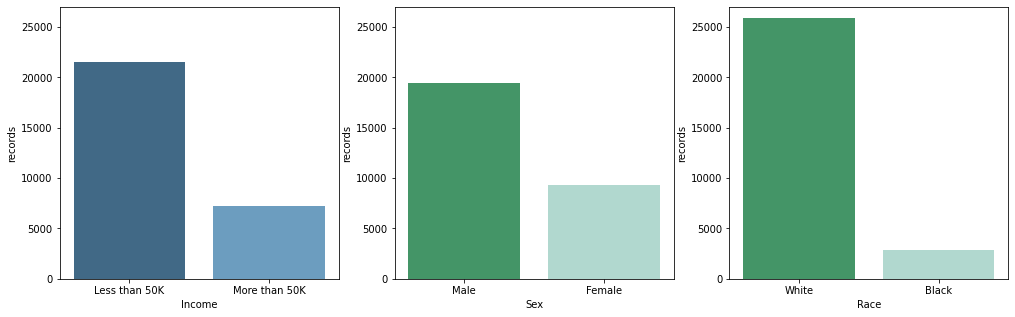

Records:
    Total: 28750
    Positive: 7205 (25.06% of total)
    Negative: 21545 (74.94% of total)
 
 Sex:
    Male: 19456 (67.67% of total)
    Female: 9294 (32.33% of total)
 
 Race:
    White: 25933 (90.20% of total)
    Black: 2817 (9.80% of total)


In [0]:
#Checking Class - Sex - Race imbalance

y_count = y.value_counts()
neg, pos = y_count[0], y_count[1]
total_y = neg + pos

s_count = Z["sex"].value_counts()
fem, male = s_count[0], s_count[1]
total_s = fem + male

r_count = Z["race"].value_counts()
black, white = r_count[0], r_count[1]
total_r = black + white

data_y = pd.DataFrame({'Income': y_count.index,'records': y_count.values})
data_y['Income'] = data_y['Income'].map({0:"Less than 50K", 1:'More than 50K'})

data_s = pd.DataFrame({'Sex': s_count.index,'records': s_count.values})
data_s['Sex'] = data_s['Sex'].map({0:"Female", 1:'Male'})

data_r = pd.DataFrame({'Race': r_count.index,'records': r_count.values})
data_r['Race'] = data_r['Race'].map({0:"Black", 1:'White'})


fig,(AX1, AX2, AX3)  = plt.subplots(ncols=3, figsize=(17,5))
AX1.set_ylim(0, 27000)
AX2.set_ylim(0, 27000)
AX3.set_ylim(0, 27000)
sns.barplot(ax = AX1, x = 'Income', y="records", data=data_y, palette="Blues_d")
sns.barplot(ax = AX2, x = 'Sex', y="records", data=data_s, palette="BuGn_r")
sns.barplot(ax = AX3, x = 'Race', y="records", data=data_r, palette="BuGn_r")
plt.show()


print('Records:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n \n Sex:\n    Male: {} ({:.2f}% of total)\n    Female: {} ({:.2f}% of total)\n \n Race:\n    White: {} ({:.2f}% of total)\n    Black: {} ({:.2f}% of total)'.format(
    total_y, pos, 100 * pos / total_y, neg, 100*neg/total_y, male, 100 * male / total_s, fem, 100*fem/total_s, white, 100 * white / total_r, black, 100*black/total_r))

 

In [0]:
# Checking Class - Sex/Race imbalance

data = pd.concat([y,Z], axis=1) 
data['sex'] = data['sex'].map({0:"Female", 1:'Male'})
data['race'] = data['race'].map({0:"Black", 1:"White"})
data["income"] = data['y'].map({0:"Less than 50K", 1:"More than 50K"})

Less than 50K:
    Female: 8238 (38.24% of total)
    Male: 13307 (61.76% of total)
    Black: 2451 (11.38% of total)
    White: 19094 (88.62% of total)

More than 50K:
    Female: 1056 (14.66% of total)
    Male: 6149 (85.34% of total)
    Black: 366 (5.08% of total)
    White: 6839 (94.92% of total)



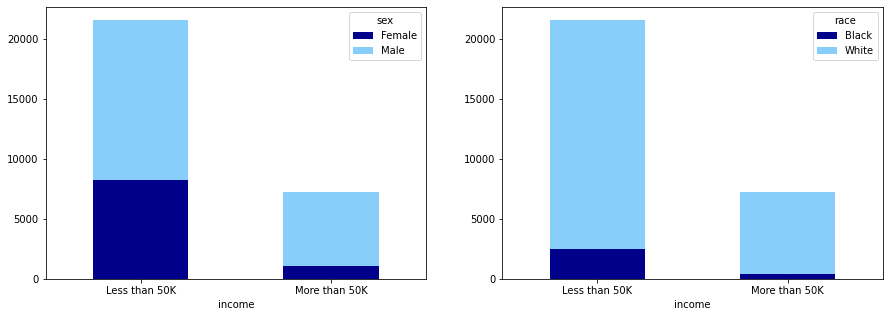

In [0]:
#Plot Class - Sex/Race imbalance

plt.figure(1)
plt.subplot(1,2,1)
data.groupby("sex").income.value_counts().unstack(0).plot.bar(ax=plt.gca(), color = ['darkblue', 'lightskyblue'], rot=0, stacked=True, figsize=(15,5))
plt.subplot(1,2,2)
data.groupby("race").income.value_counts().unstack(0).plot.bar(ax=plt.gca(), color = ['darkblue', 'lightskyblue'], rot=0, stacked=True)

s = data.groupby("income").sex.value_counts()
r = data.groupby("income").race.value_counts()

tot_s = s[0]+s[1]
tot_r = r[0]+r[1]

print('Less than 50K:\n    Female: {} ({:.2f}% of total)\n    Male: {} ({:.2f}% of total)\n    Black: {} ({:.2f}% of total)\n    White: {} ({:.2f}% of total)\n'.format(
       s[1], s[1]*100/tot_s, s[0], s[0]*100/tot_s, r[1], r[1]*100/tot_r, r[0], r[0]*100/tot_r))

tot_s = s[2]+s[3]
tot_r = r[2]+r[3]

print('More than 50K:\n    Female: {} ({:.2f}% of total)\n    Male: {} ({:.2f}% of total)\n    Black: {} ({:.2f}% of total)\n    White: {} ({:.2f}% of total)\n'.format(
       s[3], s[3]*100/tot_s, s[2], s[2]*100/tot_s, r[3], r[3]*100/tot_r, r[2], r[2]*100/tot_r))

In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28750 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             28750 non-null  int64 
 1   workclass       28750 non-null  object
 2   fnlwgt          28750 non-null  int64 
 3   education       28750 non-null  object
 4   education_num   28750 non-null  int64 
 5   marital_status  28750 non-null  object
 6   occupation      28750 non-null  object
 7   relationship    28750 non-null  object
 8   capital_gain    28750 non-null  int64 
 9   capital_loss    28750 non-null  int64 
 10  hours_per_week  28750 non-null  int64 
 11  country         28750 non-null  object
dtypes: int64(6), object(6)
memory usage: 2.9+ MB


In [0]:
X.nunique()

age                  72
workclass             7
fnlwgt            19388
education            16
education_num        16
marital_status        7
occupation           14
relationship          6
capital_gain        118
capital_loss         87
hours_per_week       94
country              39
dtype: int64

## Preprocessing

In [0]:
X.nunique()

age                  72
workclass             7
fnlwgt            19388
education            16
education_num        16
marital_status        7
occupation           14
relationship          6
capital_gain        118
capital_loss         87
hours_per_week       94
country              39
dtype: int64

In [0]:
states = X.groupby('country').size().sort_values(ascending=False)
states

country
United-States                 26847
Mexico                          563
Germany                         124
Canada                          105
El-Salvador                      96
Cuba                             90
Puerto-Rico                      87
England                          85
Jamaica                          79
Italy                            68
Guatemala                        59
Poland                           55
Columbia                         49
Dominican-Republic               48
Haiti                            41
Iran                             34
Portugal                         33
Peru                             29
Nicaragua                        29
Greece                           28
France                           27
Ireland                          23
Japan                            21
Ecuador                          18
Yugoslavia                       16
Trinadad&Tobago                  15
Outlying-US(Guam-USVI-etc)       14
Hungary             

In [0]:
#only the first 15 represented countries will be maintained. the others will be grouped in "others"
others= states[14:].index

In [0]:
X.loc[X['country'].isin(others), 'country'] = "other"
X["country"].nunique()

15

In [0]:
X.nunique()

age                  72
workclass             7
fnlwgt            19388
education            16
education_num        16
marital_status        7
occupation           14
relationship          6
capital_gain        118
capital_loss         87
hours_per_week       94
country              15
dtype: int64

In [0]:
#Creating dummy variables for categorical attributes

# workclass
X = X.merge(pd.get_dummies(X.workclass, drop_first=True, prefix='workclass'), left_index=True, right_index=True)
# marital_status
X = X.merge(pd.get_dummies(X.marital_status, drop_first=True, prefix='marital_status'), left_index=True, right_index=True)
# occupation
X = X.merge(pd.get_dummies(X.occupation, drop_first=True, prefix='occupation'), left_index=True, right_index=True)
# relationship 
X = X.merge(pd.get_dummies(X.relationship, drop_first=True, prefix='relationship'), left_index=True, right_index=True)
# country
X = X.merge(pd.get_dummies(X.country, drop_first=True, prefix='country') , left_index=True, right_index=True)


In [0]:
#Excluding the missing columns
X = X.drop(["workclass", 
              "marital_status", 
              "occupation", 
              "relationship", 
              "country",
              "education"],
            axis=1)

In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28750 entries, 0 to 32560
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   age                                   28750 non-null  int64
 1   fnlwgt                                28750 non-null  int64
 2   education_num                         28750 non-null  int64
 3   capital_gain                          28750 non-null  int64
 4   capital_loss                          28750 non-null  int64
 5   hours_per_week                        28750 non-null  int64
 6   workclass_Local-gov                   28750 non-null  uint8
 7   workclass_Private                     28750 non-null  uint8
 8   workclass_Self-emp-inc                28750 non-null  uint8
 9   workclass_Self-emp-not-inc            28750 non-null  uint8
 10  workclass_State-gov                   28750 non-null  uint8
 11  workclass_Without-pay                 287

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


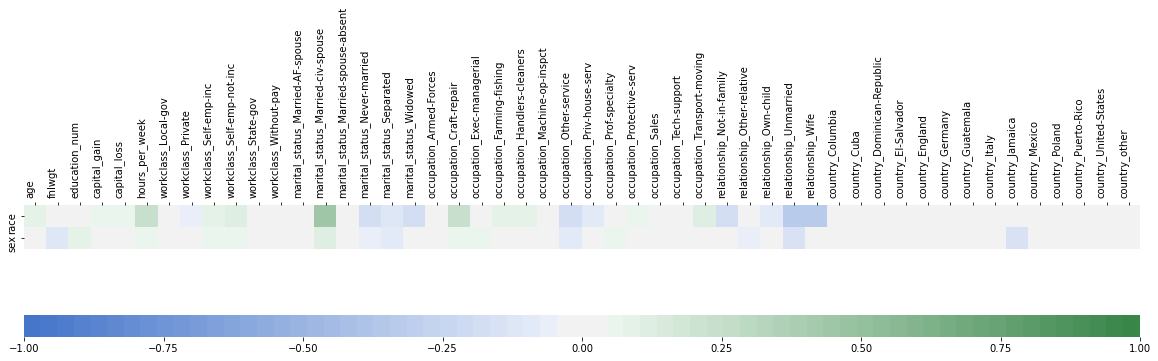

In [0]:

corr_sex = pd.DataFrame(X.corrwith(Z.sex))
corr_race = pd.DataFrame(X.corrwith(Z.race))

corr = corr_sex.join(corr_race, rsuffix='_')
corr.columns=['race', 'sex']

corr= corr.transpose()

grid_kws = {"height_ratios": (.9, .01), "hspace": (-0.9)}
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,20), gridspec_kw=grid_kws)
heat = sns.heatmap(corr, ax=ax1, vmin=-1, vmax=1, cmap=sns.diverging_palette(255, 133,n=67, center="light"), square =True, cbar_ax=ax2, cbar_kws={"orientation": "horizontal"})
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, horizontalalignment='right')
ax1.xaxis.tick_top()

In [0]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.3, 
                                                                     stratify=y, random_state=7)

# split into train/val set
X_train, X_val, y_train, y_val, Z_train, Z_val = train_test_split(X_train, y_train, Z_train, test_size=0.2, 
                                                                     stratify=y_train, random_state=7)


In [0]:
# Converting to nparray
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [0]:
# Scaling
scaler= StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

print('Training labels', y_train.shape)
print('Validation labels', y_val.shape)
print('Test labels', y_test.shape)

print('Training features', X_train.shape)
print('Validation features', X_val.shape)
print('Test features', X_test.shape)

Training labels (16100,)
Validation labels (4025,)
Test labels (8625,)
Training features (16100, 50)
Validation features (4025, 50)
Test features (8625, 50)


## Baseline Classifier

In [0]:
def nn_classifier(inputs):
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model =Model(inputs=[inputs], outputs=[outputs], name="classifier")
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [0]:
#To take care of class imbalance
def compute_class_weights(df):
    class_values = [0, 1]
    class_weights = []

    if len(df.shape) == 1:
        balanced_weights = compute_class_weight('balanced', class_values, df)
        class_weights.append(dict(zip(class_values, balanced_weights)))

    else:
        n_attr =  df.shape[1]

        for idx in range(n_attr):
            balanced_weights = compute_class_weight('balanced', class_values,
                                                    np.array(df)[:,idx])
            class_weights.append(dict(zip(class_values, balanced_weights)))

    return class_weights

In [0]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [0]:
# initialise NeuralNet Classifier
n_features=X_train.shape[1]
classifier_inputs = Input(shape=(n_features,), name="clf_input")

clf = nn_classifier(classifier_inputs)

class_weights_clf = compute_class_weights(y_train)

# train on train set
history = clf.fit(X_train, y_train, 
                  epochs=50, 
                  validation_data=(X_val, y_val),
                  verbose=1,
                  class_weight=class_weights_clf,
                  callbacks = [early_stopping])

Train on 16100 samples, validate on 4025 samples
Epoch 1/50
16100/16100 [==============================] - 1s 78us/step - loss: 0.5100 - accuracy: 0.7302 - val_loss: 0.4113 - val_accuracy: 0.7883
Epoch 2/50
16100/16100 [==============================] - 1s 67us/step - loss: 0.4249 - accuracy: 0.7862 - val_loss: 0.3915 - val_accuracy: 0.7893
Epoch 3/50
16100/16100 [==============================] - 1s 60us/step - loss: 0.4116 - accuracy: 0.7927 - val_loss: 0.3874 - val_accuracy: 0.7920
Epoch 4/50
16100/16100 [==============================] - 1s 60us/step - loss: 0.3977 - accuracy: 0.7960 - val_loss: 0.3859 - val_accuracy: 0.7948
Epoch 5/50
16100/16100 [==============================] - 1s 61us/step - loss: 0.3928 - accuracy: 0.8021 - val_loss: 0.3804 - val_accuracy: 0.7955
Epoch 6/50
16100/16100 [==============================] - 1s 59us/step - loss: 0.3873 - accuracy: 0.8071 - val_loss: 0.3891 - val_accuracy: 0.7985
Epoch 7/50
16100/16100 [==============================] - 1s 60us/ste

In [0]:
# predict on test set
probs_b = clf.predict(X_test)

In [0]:
#fairness metric
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) *100

In [0]:
# p-rules
p_rules_0 = pd.DataFrame()
p_rules_0.loc[0, 'race'] = p_rule(probs_b, Z_test['race']) 
p_rules_0.loc[0, 'sex'] = p_rule(probs_b, Z_test['sex']) 
p_rules_0 = p_rules_0.loc[0]

# metrics
val_metrics_0 = pd.DataFrame()
val_metrics_0.loc[0, 'ROC AUC'] = roc_auc_score(y_test, probs_b)
val_metrics_0.loc[0, 'Accuracy'] = (accuracy_score(y_test, (probs_b>0.5)))
val_metrics_0 = val_metrics_0.loc[0]

In [0]:
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None, zero=None,
                      val_metrics_0=None, p_rules_0=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    legend={'race': ['black','white'],
            'sex': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.distplot(y[Z[attr] == attr_val], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format(legend[attr][attr_val]), 
                              ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,4)
        ax.set_yticks([])
        ax.set_title("sensitive attibute:" + r"$\bf{}$".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
        
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16', fontweight='bold')
        a=0.48
        b=0.35
        c=0.21
    else:
        a=0.9
        b=0.77
        c=0.63  
        
    if val_metrics is not None:
        fig.text(1.0, 0.77, '\n'.join([f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.4f}"]),
                 fontsize='14')
        
    if p_rules is not None:
        fig.text(1.0, 0.63, '\n'.join([f"- {attr}: {p_rules[attr]:.0f}%-rule" for attr in p_rules.keys()]), 
                 fontsize='14')
        
    fig.text(1.0, a, f"Training iteration #0", fontsize='14', fontweight='bold')
    fig.text(1.0, b, '\n'.join([f"- ROC AUC: {val_metrics_0['ROC AUC']:.2f}",
                                    f"- Accuracy: {val_metrics_0['Accuracy']:.4f}"]),
             fontsize='12')
    fig.text(1.0, c, '\n'.join([f"- {attr}: {p_rules_0[attr]:.0f}%-rule" for attr in p_rules_0.keys()]), 
             fontsize='12')
        
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    return fig

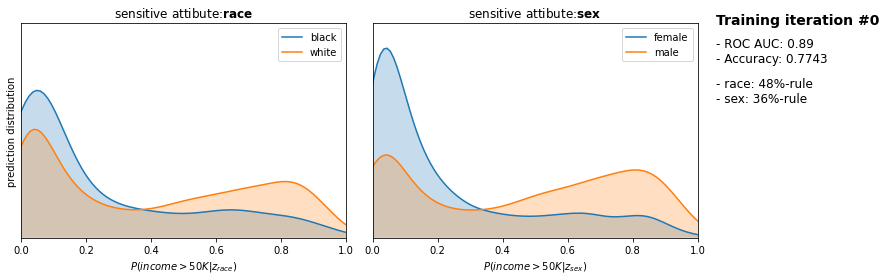

In [0]:
fig = plot_distributions(probs_b, Z_test, val_metrics_0=val_metrics_0, p_rules_0=p_rules_0)

## CAN

In [0]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
Z_train = pd.DataFrame(Z_train)

X_val = pd.DataFrame(X_val)
y_val = pd.DataFrame(y_val)
Z_val = pd.DataFrame(Z_val)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
Z_test = pd.DataFrame(Z_test)

In [0]:
#Fuction to make hidden layers trainable
def _make_trainable(net):
    def make_trainable(flag):
        net.trainable = flag
        for layer in net.layers:
            layer.trainable = flag
    return make_trainable

In [0]:
#Classifier net
def build_classifier(inputs):
    dense1 = Dense(32, activation='relu', name="dense_1")(inputs)
    dropout1 = Dropout(0.2, name="dropout_1")(dense1)
    dense2 = Dense(32, activation='relu', name="dense_2")(dropout1)
    dropout2 = Dropout(0.2, name="dropout_2")(dense2)
    dense3 = Dense(32, activation='relu', name="dense_3")(dropout2)
    dropout3 = Dropout(0.2, name="dropout_3")(dense3)
    outputs = Dense(1, activation='sigmoid', name='y')(dropout3)
    return Model(inputs=[inputs], outputs=[outputs], name="classifier")

In [0]:
#Adversial net
def build_adversial(inputs, n_sensitive):
    dense1 = Dense(32, activation='relu', name="dense_1")(inputs)
    dense2 = Dense(32, activation='relu', name="dense_2")(dense1)
    dense3 = Dense(32, activation='relu', name="dense_3")(dense2)
    outputs = [Dense(1, activation='sigmoid', name="adv_output_{:>01}".format(i))(dense3) for i in range(n_sensitive)]
    return Model(inputs=[inputs], outputs=outputs, name="adversial")


In [0]:
#Compile classifier
def compile_classifier(classifier):
    trainable_classifier = _make_trainable(classifier)
    trainable_classifier(True)
    classifier.compile(loss='binary_crossentropy', optimizer=Adam())
    return classifier

In [0]:
#Compile Classification - Adversial Net
def compile_can(inputs, classifier, adversial, lambda_0, lambda_1):
    #lambdas= [lambda_0, lambda_1]
    can = Model(inputs=[inputs], outputs=[classifier(inputs)]+adversial(classifier(inputs)), name="can")
    trainable_classifier = _make_trainable(classifier)
    trainable_adversial = _make_trainable(adversial)
    trainable_classifier(True)
    trainable_adversial(False)
    loss_weights = [1.]+[-lambda_0]+[-lambda_1]
    can.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                      loss_weights=loss_weights,
                      optimizer=Adam())
    return can

In [0]:
#Compile Adversial Net (same as Classification-Adversial but with only two outputs corresponding to the sensitive attributes)
def compile_adversial(inputs, classifier, adversial, n_sensitive):
    adv = Model(inputs=[inputs], outputs=adversial(classifier(inputs)))
    trainable_classifier = _make_trainable(classifier)
    trainable_adversial = _make_trainable(adversial)
    trainable_classifier(False)
    trainable_adversial(True)
    adv.compile(loss=['binary_crossentropy']*n_sensitive, optimizer=Adam())
    return adv

In [0]:
#Pretraining phase
def pretrain(x, y, z, classifier, adversial, epochs=10, verbose=0):
    print('Pretraining phase..')  
    trainable_classifier = _make_trainable(classifier)
    trainable_adversial = _make_trainable(adversial)
    trainable_classifier(True)
    class_weight_clf = compute_class_weights(y)
    classifier.fit(x.values, y.values, epochs=epochs, verbose=verbose, class_weight=class_weight_clf)
    trainable_classifier(False)
    trainable_adversial(True)
    class_weight_adv = compute_class_weights(z)
    adversial.fit(x.values, np.hsplit(z.values, z.shape[1]), class_weight=class_weight_adv, 
                  epochs=epochs, verbose=verbose)
    

In [0]:
#Learning phase
def fit(x, y, z, classifier, adversial, can, validation_data=None, epochs=250, batch_size=128, save_figs=False, stop_condition=80, plot_dist=False):
    print("learning phase..")
    n_sensitive = z.shape[1]

    if validation_data is not None:
        x_val, y_val, z_val = validation_data

    class_weight_adv = compute_class_weights(z)
    class_weight_clf = compute_class_weights(y)
    class_weight_can = class_weight_clf + class_weight_adv

    val_metrics = pd.DataFrame()
    fairness_metrics = pd.DataFrame()  
    delta_f_0 = pd.DataFrame()
    delta_f_1 = pd.DataFrame()
    delta_a = pd.DataFrame()
    
    trainable_classifier = _make_trainable(classifier)
    trainable_adversial = _make_trainable(adversial)

    for idx in range(epochs):

        if validation_data is not None:

            y_pred = can.predict(x_val)[0]
            val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
            val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5)))
            delta_a.loc[idx, "Accuracy"] =  val_metrics.loc[idx]['Accuracy']- val_metrics.loc[0]['Accuracy']


            for sensitive_attr in z_val.columns:
                fairness_metrics.loc[idx, sensitive_attr] = p_rule(y_pred, z_val[sensitive_attr])  
                
            delta_f_0.loc[idx, "race"] =  (fairness_metrics.loc[idx]['race']/100) - (fairness_metrics.loc[0]['race']/100)
            delta_f_1.loc[idx, "sex"] =  (fairness_metrics.loc[idx]['sex']/100) - (fairness_metrics.loc[0]['sex']/100)

            if plot_dist:
                display.clear_output(wait=True)
                
                plot_distributions(y_pred, z_val, idx+1, val_metrics.loc[idx],
                                  fairness_metrics.loc[idx],
                                  val_metrics_0=val_metrics.loc[0], p_rules_0=fairness_metrics.loc[0],
                                  fname=f'output{idx+1:08d}.png' if save_figs else None)

                plt.show(plt.gcf())
            
        # train adverserial
        trainable_classifier(False)
        trainable_adversial(True)
        h_a = adversial.fit(x.values, np.hsplit(z.values, z.shape[1]), batch_size=batch_size, epochs=1, class_weight=class_weight_adv, 
                            verbose=0)

        # train classifier
        trainable_classifier(True)
        trainable_adversial(False)
        indices = np.random.permutation(len(x))[:batch_size]
        h_c = can.train_on_batch(x.values[indices],
                                 [y.values[indices]]+np.hsplit(z.values[indices],n_sensitive), class_weight=class_weight_can)

        obj = -(((delta_f_0["race"][idx]/ (abs(delta_a["Accuracy"][idx])))/100) + ((delta_f_1["sex"][idx]/ (abs(delta_a["Accuracy"][idx])))/100))
        
        ep = idx+1

        if (fairness_metrics["race"][idx] > stop_condition and fairness_metrics["sex"][idx] > stop_condition):
                print('Number of Epochs needed to obtain fairness:', ep)
                print('delta p-rule race:', delta_f_0["race"][idx])
                print('delta p-rule sex:', delta_f_1["sex"][idx])
                print('delta accuracy:', delta_a["Accuracy"][idx])

                return obj
    
    print('Fairness not reached in 300 epochs:')
    return obj

In [0]:
def can(cfg):
    print("Testing configuration: \n     lambda 0:", cfg['lambda_0'], "   lambda 1: ",cfg['lambda_1'])
    n_features=X_train.shape[1]
    n_sensitive=Z_train.shape[1]
    pre_epochs=5
    pre_verbose=0 
    val_data=(X_val, y_val, Z_val)
    epochs=300
    stop_cond = 80

    classifier_inputs = Input(shape=(n_features,), name="clf_input")
    adversial_inputs = Input(shape=(1,), name="adv_input")

    classifier = build_classifier(classifier_inputs)
    adversial = build_adversial(adversial_inputs, n_sensitive)

    classifier = compile_classifier(classifier)
    can = compile_can(classifier_inputs, classifier, adversial, cfg["lambda_0"], cfg["lambda_1"])
    adversial = compile_adversial(classifier_inputs, classifier, adversial, n_sensitive)
    
    pretrain(X_train, y_train, Z_train, classifier, adversial, verbose=pre_verbose, epochs=pre_epochs)

    fitted = fit(X_train, y_train, Z_train, classifier, adversial, can, 
        validation_data=val_data,
        epochs=epochs, stop_condition=stop_cond)
    
    return fitted

### Hyperoptimization

In [0]:
# defining results dictionary that will be populated when experiments run
res = {}

In [0]:
# Hyperparameters range

#Lambdas
lambda_0_lower = 1.
lambda_0_upper = 200.
lambda_1_lower = 1.
lambda_1_upper = 200.

In [0]:
lambda_0 = UniformFloatHyperparameter("lambda_0", 
                                        lower=lambda_0_lower, 
                                        upper=lambda_0_upper)

lambda_1 = UniformFloatHyperparameter("lambda_1", 
                                        lower=lambda_1_lower, 
                                        upper=lambda_1_upper)

In [0]:
# Build Configuration Space which defines all parameters and their ranges
cs= ConfigurationSpace()

In [0]:
cs.add_hyperparameters([lambda_0, lambda_1])

[lambda_0, Type: UniformFloat, Range: [1.0, 200.0], Default: 100.5,
 lambda_1, Type: UniformFloat, Range: [1.0, 200.0], Default: 100.5]

In [0]:
initial_runs = 5
further_runs = 45

In [0]:
initial_configs = cs.sample_configuration(size = initial_runs)
initial_configs

[Configuration:
   lambda_0, Value: 98.627065781744
   lambda_1, Value: 110.16579592071132, Configuration:
   lambda_0, Value: 52.5592772559921
   lambda_1, Value: 28.13034649286336, Configuration:
   lambda_0, Value: 181.6624629896231
   lambda_1, Value: 125.66347135805258, Configuration:
   lambda_0, Value: 161.17921370391667
   lambda_1, Value: 60.77312866420032, Configuration:
   lambda_0, Value: 20.324855565240238
   lambda_1, Value: 52.59802830804566]

In [0]:
scenario = Scenario({"run_obj": "quality",
                     "runcount-limit":initial_runs+ further_runs,
                     "cs":cs,
                     "deterministic":"true"
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2020-04-29_10:24:17_341521


In [0]:
# defining function that run and optimize smac
def run_smac(acquisition_function):
    smac = SMAC4HPO(scenario=scenario, 
                   tae_runner=can,
                   initial_design_kwargs={'configs': initial_configs},
                   acquisition_function=acquisition_function
                   )

    incumbent = smac.optimize()

    bestseen = 1-np.minimum.accumulate(list(
        smac.get_runhistory()._cost_per_config.values()
        ))
    
    # put best configuration and bestseen in results dictionary
    res[f"HPO - {acquisition_function.__name__}"] = {
    'best_config': list(incumbent._values.values()),
    'bestseen': bestseen,
    }

    return incumbent, smac

In [0]:
EI_cfg, _ = run_smac(EI)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Testing configuration: 
     lambda 0: 98.627065781744    lambda 1:  110.16579592071132
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 110
delta p-rule race: 0.288660357600218
delta p-rule sex: 0.6032301988707505
delta accuracy: -0.029068322981366412


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.3068


Testing configuration: 
     lambda 0: 52.5592772559921    lambda 1:  28.13034649286336
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 118
delta p-rule race: 0.29755668892461673
delta p-rule sex: 0.49358481504796575
delta accuracy: -0.022608695652173938


INFO:smac.intensification.intensification.Intensifier:Challenger (-0.3499) is better than incumbent (-0.3068) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  lambda_0 : 98.627065781744 -> 52.5592772559921
INFO:smac.intensification.intensification.Intensifier:  lambda_1 : 110.16579592071132 -> 28.13034649286336
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.3499


Testing configuration: 
     lambda 0: 181.6624629896231    lambda 1:  125.66347135805258
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 109
delta p-rule race: 0.30819668686397617
delta p-rule sex: 0.5366502175177621
delta accuracy: -0.01788819875776393


INFO:smac.intensification.intensification.Intensifier:Challenger (-0.4723) is better than incumbent (-0.3499) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  lambda_0 : 52.5592772559921 -> 181.6624629896231
INFO:smac.intensification.intensification.Intensifier:  lambda_1 : 28.13034649286336 -> 125.66347135805258
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.4723


Testing configuration: 
     lambda 0: 161.17921370391667    lambda 1:  60.77312866420032
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 120
delta p-rule race: 0.3811287617689664
delta p-rule sex: 0.45683147828334186
delta accuracy: -0.022111801242235996


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.4723


Testing configuration: 
     lambda 0: 20.324855565240238    lambda 1:  52.59802830804566
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 114
delta p-rule race: 0.27383973398603945
delta p-rule sex: 0.6233591873523016
delta accuracy: -0.05093167701863355


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.4723


Testing configuration: 
     lambda 0: 175.2680323965388    lambda 1:  142.2122114549463
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 106
delta p-rule race: 0.2748347303313955
delta p-rule sex: 0.5149263671351405
delta accuracy: -0.032298136645962705


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.4723


Testing configuration: 
     lambda 0: 181.66386166134967    lambda 1:  138.9465668629769
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 103
delta p-rule race: 0.2975342735379234
delta p-rule sex: 0.6016514722700987
delta accuracy: -0.05440993788819881


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.4723


Testing configuration: 
     lambda 0: 181.16716160747742    lambda 1:  60.5017846917091
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 126
delta p-rule race: 0.27876457644789787
delta p-rule sex: 0.5392531511865362
delta accuracy: -0.01043478260869568


INFO:smac.intensification.intensification.Intensifier:Challenger (-0.7839) is better than incumbent (-0.4723) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  lambda_0 : 181.6624629896231 -> 181.16716160747742
INFO:smac.intensification.intensification.Intensifier:  lambda_1 : 125.66347135805258 -> 60.5017846917091
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.7839


Testing configuration: 
     lambda 0: 185.54016235801075    lambda 1:  60.215102797900485
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 117
delta p-rule race: 0.2384312945515621
delta p-rule sex: 0.4332008879444128
delta accuracy: -0.004968944099378869


INFO:smac.intensification.intensification.Intensifier:Challenger (-1.3517) is better than incumbent (-0.7839) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  lambda_0 : 181.16716160747742 -> 185.54016235801075
INFO:smac.intensification.intensification.Intensifier:  lambda_1 : 60.5017846917091 -> 60.215102797900485
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -1.3517


Testing configuration: 
     lambda 0: 38.38624401653409    lambda 1:  81.62079095053586
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 127
delta p-rule race: 0.2926031807288667
delta p-rule sex: 0.5951705498550142
delta accuracy: -0.04571428571428571


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -1.3517


Testing configuration: 
     lambda 0: 195.79686725353656    lambda 1:  16.362649870524194
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 191
delta p-rule race: 0.4445588359112337
delta p-rule sex: 0.4284031580291767
delta accuracy: -0.009689440993788878


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -1.3517


Testing configuration: 
     lambda 0: 185.4094796461984    lambda 1:  131.12685951441853
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 96
delta p-rule race: 0.2684415440319382
delta p-rule sex: 0.548214843276875
delta accuracy: -0.026583850931677033


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -1.3517


Testing configuration: 
     lambda 0: 189.00631262197305    lambda 1:  140.90838199632023
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 104
delta p-rule race: 0.2834047309151597
delta p-rule sex: 0.5724888943593155
delta accuracy: -0.03527950310559003


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -1.3517


Testing configuration: 
     lambda 0: 185.58521967134513    lambda 1:  54.347378083316705
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 126
delta p-rule race: 0.30571657993361034
delta p-rule sex: 0.4331280819763783
delta accuracy: -0.027329192546583947


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -1.3517


Testing configuration: 
     lambda 0: 185.49300522815597    lambda 1:  59.089180923437716
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 97
delta p-rule race: 0.3136301538643511
delta p-rule sex: 0.4343821016747344
delta accuracy: -0.0536645962732919


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -1.3517


Testing configuration: 
     lambda 0: 180.71962045908023    lambda 1:  182.99754521055294
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 80
delta p-rule race: 0.23785705982637328
delta p-rule sex: 0.45964170223359324
delta accuracy: -0.05341614906832293


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -1.3517


Testing configuration: 
     lambda 0: 16.3439441790766    lambda 1:  52.59802830804566
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 108
delta p-rule race: 0.26746782596766216
delta p-rule sex: 0.5971116666687462
delta accuracy: -0.06509316770186335


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -1.3517


Testing configuration: 
     lambda 0: 185.5386900457444    lambda 1:  60.23258786364987
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 116
delta p-rule race: 0.30606573806993376
delta p-rule sex: 0.42347824163414344
delta accuracy: 0.0019875776397515477


INFO:smac.intensification.intensification.Intensifier:Challenger (-3.6705) is better than incumbent (-1.3517) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  lambda_0 : 185.54016235801075 -> 185.5386900457444
INFO:smac.intensification.intensification.Intensifier:  lambda_1 : 60.215102797900485 -> 60.23258786364987
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 185.53638742710098    lambda 1:  184.73118573382297
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 122
delta p-rule race: 0.27364919990188274
delta p-rule sex: 0.6098902857120532
delta accuracy: -0.032795031055900536


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 185.54016235801075    lambda 1:  80.83129228419895
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 117
delta p-rule race: 0.2902347805776264
delta p-rule sex: 0.5413874603516571
delta accuracy: -0.03925465838509323


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 185.5386900457444    lambda 1:  88.97899112282869
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 78
delta p-rule race: 0.288449226819139
delta p-rule sex: 0.46061958764781585
delta accuracy: -0.07875776397515521


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 195.79686725353656    lambda 1:  13.157548422601215
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 167
delta p-rule race: 0.41488919713678074
delta p-rule sex: 0.40308554924500745
delta accuracy: -0.019130434782608674


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 185.5386900457444    lambda 1:  60.30716061898483
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 125
delta p-rule race: 0.32306186502706746
delta p-rule sex: 0.40482543829415835
delta accuracy: -0.01788819875776393


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 195.79686725353656    lambda 1:  12.5450114059564
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 173
delta p-rule race: 0.43471108222944466
delta p-rule sex: 0.43124363833861257
delta accuracy: -0.00521739130434784


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 46.169753349693785    lambda 1:  57.189650601206935
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 115
delta p-rule race: 0.25569891752209195
delta p-rule sex: 0.5850315913103938
delta accuracy: -0.05167701863354035


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 156.72239366973307    lambda 1:  90.6228873503198
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 87
delta p-rule race: 0.30097456679496604
delta p-rule sex: 0.41160041839929823
delta accuracy: -0.039751552795031064


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 195.79686725353656    lambda 1:  4.313415433301127
Pretraining phase..
learning phase..
Fairness not reached in 300 epochs:


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 123.26218757819704    lambda 1:  146.8077975690301
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 125
delta p-rule race: 0.2905464419236169
delta p-rule sex: 0.5565536357845404
delta accuracy: -0.0551552795031055


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 161.22547884915866    lambda 1:  60.77312866420032
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 109
delta p-rule race: 0.30976658753826647
delta p-rule sex: 0.45983444127340056
delta accuracy: -0.022608695652173938


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 193.76431825441793    lambda 1:  60.243002691247575
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 99
delta p-rule race: 0.3182444614079244
delta p-rule sex: 0.4604308612953248
delta accuracy: 0.003975155279503095


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 185.58521967134513    lambda 1:  44.377348925057575
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 114
delta p-rule race: 0.3861815925205837
delta p-rule sex: 0.4403003868246977
delta accuracy: -0.06335403726708067


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 193.86354496554438    lambda 1:  60.243002691247575
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 110
delta p-rule race: 0.32464080864575295
delta p-rule sex: 0.41859598119642255
delta accuracy: -0.03577639751552797


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 185.5386900457444    lambda 1:  59.97550402415032
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 106
delta p-rule race: 0.2882460303803758
delta p-rule sex: 0.46561695791554003
delta accuracy: -0.017391304347825987


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 185.5386900457444    lambda 1:  82.86137399181507
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 135
delta p-rule race: 0.29567681313552185
delta p-rule sex: 0.5963132832043672
delta accuracy: -0.003975155279503095


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 185.5386900457444    lambda 1:  92.3053903887846
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 81
delta p-rule race: 0.2495533475080104
delta p-rule sex: 0.40588526693176286
delta accuracy: -0.022360248447204967


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 186.90397027969885    lambda 1:  135.51586488350438
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 93
delta p-rule race: 0.2575259534922235
delta p-rule sex: 0.4565342136188469
delta accuracy: -0.01540372670807455


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 196.39448402310242    lambda 1:  4.313415433301127
Pretraining phase..
learning phase..
Fairness not reached in 300 epochs:


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 184.6222408526721    lambda 1:  61.66597263942724
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 107
delta p-rule race: 0.3219269667789185
delta p-rule sex: 0.428657439672353
delta accuracy: -0.05341614906832293


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 87.653406933952    lambda 1:  107.11694543532101
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 93
delta p-rule race: 0.27659395314370716
delta p-rule sex: 0.6042737214594167
delta accuracy: -0.03527950310559003


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 187.9472181950678    lambda 1:  83.18570091680597
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 83
delta p-rule race: 0.31417684080541874
delta p-rule sex: 0.4196345837592377
delta accuracy: -0.026832298136646004


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 117.87111258018687    lambda 1:  27.242895348891988
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 127
delta p-rule race: 0.3470141649818773
delta p-rule sex: 0.42831323484603706
delta accuracy: -0.04695652173913034


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 81.92041760461338    lambda 1:  60.24498366472428
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 102
delta p-rule race: 0.2804956298100151
delta p-rule sex: 0.5690707292321735
delta accuracy: -0.037267080745341574


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 69.65187206517717    lambda 1:  60.24498366472428
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 131
delta p-rule race: 0.28547619416410186
delta p-rule sex: 0.5428692541167394
delta accuracy: -0.003726708074534235


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 22.774436128409242    lambda 1:  60.20299056254771
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 120
delta p-rule race: 0.25438885175074133
delta p-rule sex: 0.5773201183227945
delta accuracy: -0.08074534161490676


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 70.63807801305552    lambda 1:  83.25859918144651
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 101
delta p-rule race: 0.2923536940665853
delta p-rule sex: 0.6066698283305956
delta accuracy: -0.04372670807453416


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 185.5386900457444    lambda 1:  60.22496442257148
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 105
delta p-rule race: 0.3461062454239089
delta p-rule sex: 0.42232423402550257
delta accuracy: -0.03875776397515529


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 172.0382661549498    lambda 1:  108.6083337840837
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 127
delta p-rule race: 0.28268431833230323
delta p-rule sex: 0.5452786848279854
delta accuracy: -0.017142857142857237


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 65.03165512383906    lambda 1:  60.24498366472428
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 75
delta p-rule race: 0.27383701193208454
delta p-rule sex: 0.5434878781088766
delta accuracy: -0.06881987577639748


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 32.785116073885014    lambda 1:  162.8451143973015
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 98
delta p-rule race: 0.2740356003333688
delta p-rule sex: 0.5805492230649658
delta accuracy: -0.062360248447205


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -3.6705


Testing configuration: 
     lambda 0: 68.65483930084963    lambda 1:  9.682183989593486
Pretraining phase..
learning phase..
Number of Epochs needed to obtain fairness: 158
delta p-rule race: 0.334660581973542
delta p-rule sex: 0.4236319618418639
delta accuracy: -0.022608695652173938


INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 4
INFO:smac.stats.stats.Stats:#Target algorithm runs: 50 / 50.0
INFO:smac.stats.stats.Stats:#Configurations: 50
INFO:smac.stats.stats.Stats:Used wallclock time: 2668.56 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 2636.32 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  lambda_0, Value: 185.5386900457444
  lambda_1, Value: 60.23258786364987

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Estimated cost of incumbent: -3.670518


In [0]:
delta_fair_race = pd.Series([0.288660357600218,0.30819668686397617,0.3811287617689664,0.27383973398603945,0.2748347303313955,0.2975342735379234,0.27876457644789787,
                   0.2384312945515621,0.2926031807288667,0.4445588359112337,0.2684415440319382,0.2834047309151597,0.30571657993361034,0.3136301538643511,
                   0.23785705982637328,0.26746782596766216,0.30606573806993376,0.27364919990188274,0.2902347805776264,0.288449226819139,0.41488919713678074,
                   0.32306186502706746,0.43471108222944466,0.25569891752209195,0.30097456679496604,0.2905464419236169,0.30976658753826647,0.3182444614079244,
                   0.3861815925205837,0.32464080864575295,0.2882460303803758,0.29567681313552185,0.2495533475080104,0.2575259534922235,0.3219269667789185,
                   0.27659395314370716,0.31417684080541874,0.3470141649818773,0.2804956298100151,0.28547619416410186,0.25438885175074133,0.2923536940665853,
                   0.3461062454239089,0.28268431833230323,0.27383701193208454,0.2740356003333688,0.334660581973542])

In [0]:
delta_fair_sex = pd.Series([0.6032301988707505,0.5366502175177621,0.45683147828334186,0.6233591873523016,0.5149263671351405,0.6016514722700987,0.5392531511865362,
                  0.4332008879444128,0.5951705498550142,0.4284031580291767,0.548214843276875,0.5724888943593155,0.4331280819763783,0.4343821016747344,
                  0.45964170223359324,0.5971116666687462,0.42347824163414344,0.6098902857120532,0.5413874603516571,0.46061958764781585,0.40308554924500745,
                  0.40482543829415835,0.43124363833861257,0.5850315913103938,0.41160041839929823,0.5565536357845404,0.45983444127340056,0.4604308612953248,
                  0.4403003868246977,0.41859598119642255,0.46561695791554003,0.5963132832043672,0.40588526693176286,0.4565342136188469,0.428657439672353,
                  0.6042737214594167,0.4196345837592377,0.42831323484603706,0.5690707292321735,0.5428692541167394,0.5773201183227945,0.6066698283305956,
                  0.42232423402550257,0.5452786848279854,0.5434878781088766,0.5805492230649658,0.42363196184186398])

In [0]:
delta_accuracy = pd.Series([-0.029068322981366412,-0.01788819875776393,-0.022111801242235996,-0.05093167701863355,-0.032298136645962705,-0.05440993788819881,-0.01043478260869568,
                  -0.004968944099378869,-0.04571428571428571,-0.009689440993788878,-0.026583850931677033,-0.03527950310559003,-0.027329192546583947,-0.0536645962732919,
                  -0.05341614906832293,-0.06509316770186335,0.0019875776397515477,-0.032795031055900536,-0.03925465838509323,-0.07875776397515521,-0.019130434782608674,
                  -0.01788819875776393,-0.00521739130434784,-0.05167701863354035,-0.039751552795031064,-0.0551552795031055,-0.022608695652173938,0.003975155279503095,
                  -0.06335403726708067,-0.03577639751552797,-0.017391304347825987,-0.003975155279503095,-0.022360248447204967,-0.01540372670807455,-0.05341614906832293,
                  -0.03527950310559003,-0.026832298136646004,-0.04695652173913034,-0.037267080745341574,-0.003726708074534235,-0.08074534161490676,-0.04372670807453416,
                  -0.03875776397515529,-0.017142857142857237,-0.06881987577639748,-0.062360248447205,-0.022608695652173938])

In [0]:
opt_metrics = pd.concat([delta_fair_race, delta_fair_sex, delta_accuracy], axis=1)
opt_metrics.columns = ["p-rule race", "p-rule sex", "accuracy"]

In [0]:
opt_metrics["bestseen"] = 0
opt_metrics["bestseen"][1,2,7,8,17] = 1

In [0]:
markers_on = [1,2,7,8,17]

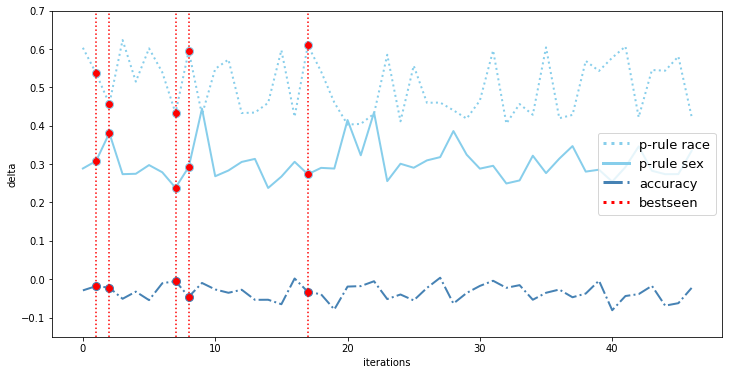

In [0]:
plt.figure(figsize=(12,6))
plt.plot('p-rule race', data=opt_metrics, markevery=markers_on, 
         marker="o", markerfacecolor='red', markersize=8, 
         color='skyblue', linewidth=2)
plt.plot('p-rule sex', data=opt_metrics, markevery=markers_on,
         marker="o", markerfacecolor='red', markersize=8, 
         color='skyblue', linewidth=2, linestyle=':')
plt.plot('accuracy', data=opt_metrics, markevery=markers_on,  
         marker="o", markerfacecolor='red', markersize=8, 
         color='steelblue', linewidth=2, linestyle='-.')

plt.xlabel('iterations')
plt.ylabel('delta')

plt.axvline(x=1, linestyle=':', color='red')
plt.axvline(x=2, linestyle=':', color='red')
plt.axvline(x=7, linestyle=':', color='red')
plt.axvline(x=8, linestyle=':', color='red')
plt.axvline(x=17, linestyle=':', color='red')

plt.ylim(-0.15,0.7)

line_1 = Line2D([0], [0], color='skyblue', linewidth=3, linestyle=':')
line_2 = Line2D([0], [0], color='skyblue', linewidth=3)
line_3 = Line2D([0], [0], color='steelblue', linewidth=3, linestyle='-.')
line_4 = Line2D([0], [0], color='red', linewidth=3, linestyle=':')
lines=[line_1, line_2, line_3, line_4]
labels = ['p-rule race', 'p-rule sex', 'accuracy', 'bestseen']
plt.legend(lines, labels, loc=5, prop={'size': 13})



## Evaluations

In [0]:
# plot the evolution of "best seen" 
def plot_bestseen(dic, runs):
  x_ax = np.arange(runs)
  plt.figure(figsize=(15, 8))
  ax = plt.subplot(111)
  for alg in dic:
    ax.plot(x_ax, dic[alg]['bestseen'], label=alg)
  ax.legend(loc='upper center', 
            bbox_to_anchor=(0.5, -0.05), 
            shadow=True, 
            ncol=2)
  plt.title('Best Seen')
  plt.show()

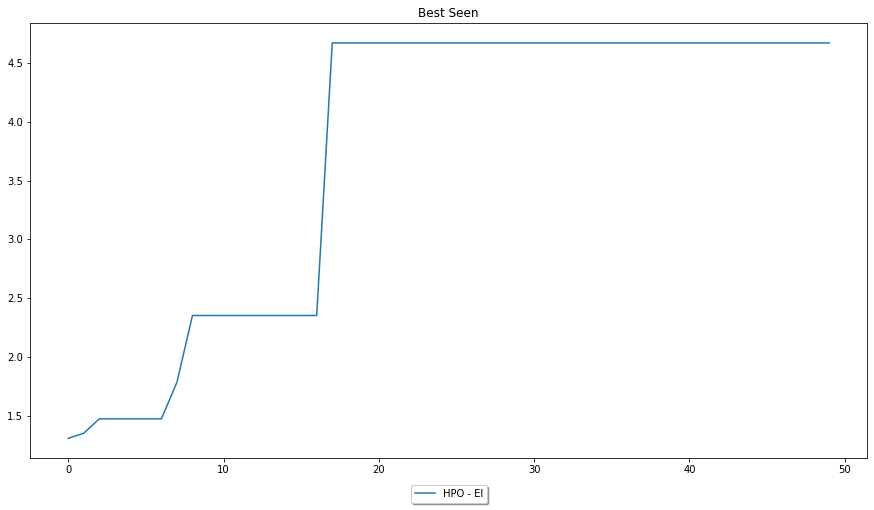

In [0]:
plot_bestseen(res, 50)

In [0]:
res['HPO - EI']

{'best_config': [185.5386900457444, 60.23258786364987],
 'bestseen': array([1.3068256 , 1.34992797, 1.47229289, 1.47229289, 1.47229289,
        1.47229289, 1.47229289, 1.78393366, 2.35165977, 2.35165977,
        2.35165977, 2.35165977, 2.35165977, 2.35165977, 2.35165977,
        2.35165977, 2.35165977, 4.67051815, 4.67051815, 4.67051815,
        4.67051815, 4.67051815, 4.67051815, 4.67051815, 4.67051815,
        4.67051815, 4.67051815, 4.67051815, 4.67051815, 4.67051815,
        4.67051815, 4.67051815, 4.67051815, 4.67051815, 4.67051815,
        4.67051815, 4.67051815, 4.67051815, 4.67051815, 4.67051815,
        4.67051815, 4.67051815, 4.67051815, 4.67051815, 4.67051815,
        4.67051815, 4.67051815, 4.67051815, 4.67051815, 4.67051815])}

In [0]:
cfg_ei={"lambda_0":res['HPO - EI']['best_config'][0],
     "lambda_1":res['HPO - EI']['best_config'][1]}

In [0]:
def can(cfg):
    print("Testing configuration: \n     lambda 0:", cfg['lambda_0'], "   lambda 1: ",cfg['lambda_1'])
    n_features=X_train.shape[1]
    n_sensitive=Z_train.shape[1]
    pre_epochs=5
    pre_verbose=0 
    val_data=(X_val, y_val, Z_val)
    epochs=300
    stop_cond = 80

    classifier_inputs = Input(shape=(n_features,), name="clf_input")
    adversial_inputs = Input(shape=(1,), name="adv_input")

    classifier = build_classifier(classifier_inputs)
    adversial = build_adversial(adversial_inputs, n_sensitive)

    classifier = compile_classifier(classifier)
    can = compile_can(classifier_inputs, classifier, adversial, cfg["lambda_0"], cfg["lambda_1"])
    adversial = compile_adversial(classifier_inputs, classifier, adversial, n_sensitive)
    
    pretrain(X_train, y_train, Z_train, classifier, adversial, verbose=pre_verbose, epochs=pre_epochs)

    fitted = fit(X_train, y_train, Z_train, classifier, adversial, can, 
        validation_data=val_data,
        epochs=epochs, stop_condition=stop_cond, plot_dist=True,
        save_figs=True)
        
    return classifier



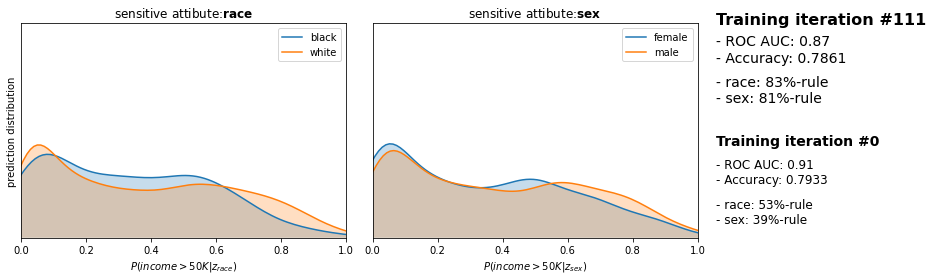

Number of Epochs needed to obtain fairness: 111
delta p-rule race: 0.3008778128756404
delta p-rule sex: 0.42688143753293323
delta accuracy: -0.007204968944099388


In [0]:
can_ei = can(cfg_ei)


In [0]:
probs_can_ei = can_ei.predict(X_test)
preds_can_ei = probs_can_ei>0.5

In [0]:
CR = classification_report(y_test, preds_can_ei)
cm = confusion_matrix(y_test, preds_can_ei)

print("CAN")
print(CR)
print(cm)

CAN
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      6463
           1       0.53      0.74      0.61      2162

    accuracy                           0.77      8625
   macro avg       0.71      0.76      0.72      8625
weighted avg       0.80      0.77      0.78      8625

[[5026 1437]
 [ 571 1591]]


In [0]:
preds_b = probs_b>0.5

In [0]:
CR = classification_report(y_test, preds_b)
cm = confusion_matrix(y_test, preds_b)

print("baseline")
print(CR)
print(cm)

baseline
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      6463
           1       0.53      0.86      0.66      2162

    accuracy                           0.77      8625
   macro avg       0.74      0.80      0.74      8625
weighted avg       0.84      0.77      0.79      8625

[[4819 1644]
 [ 303 1859]]


In [0]:
from google.colab import files
files.download('/content/output00000070.png')